In [21]:
import os 
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [2]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category, subfolder)
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [3]:
def img_is_in_ratio(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [4]:
grey_scale_limit = 10

def img_has_atleast_black_pixels(img, threshold = 5):
    height, width = img.shape
    percent = (np.sum(img <= grey_scale_limit)*100)/(width*height)
    return percent >= threshold

In [5]:
all_images = []
all_categories = []

max_ratio_threshold = 1.6
all_images_index_ratio = []

min_black_pixels_threshold = 5
all_images_indexes_black_pixels = []

all_images_index_ratio_and_black_pixels = []

datasetX = []
datasetY = []

image_size = (800, 800)

def load_datasets(img, category, subfolder):
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

    if img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold):
        all_images_indexes_black_pixels.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold) and img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio_and_black_pixels.append(len(all_images)-1)

    
browse_imgs(load_datasets)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)
 
def use_ratio_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio])

def use_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_indexes_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_indexes_black_pixels])

def use_ratio_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio_and_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio_and_black_pixels])

# use_all_dataset()
# print("Dataset all shape : ", datasetX.shape)
# use_black_pixel_dataset()
# print("Dataset bp shape : ", datasetX.shape)
# use_ratio_dataset()
# print("Dataset ration shape : ", datasetX.shape)
# use_ratio_black_pixel_dataset()
# print("Dataset bp+ratio shape : ", datasetX.shape)


In [ ]:
# def cross_val(model, load_dataset_function, scoring, nb_folds=5):
#     load_dataset_function()
#     return cross_validate(model, datasetX, datasetY, cv=nb_folds, scoring=scoring)

# def fit_and_score_each_dataset(model, scoring):
#     res = {}

#     res["all"] = (cross_val(model, use_all_dataset, scoring))
    
#     use_all_dataset()
#     X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
#     model.fit(X_train, y_train)
#     res["all"] = model.score(X_test, y_test)
    
#     use_black_pixel_dataset()
#     X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
#     model.fit(X_train, y_train)
#     res["black_pixel"] = model.score(X_test, y_test)
    
#     use_ratio_dataset()
#     X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
#     model.fit(X_train, y_train)
#     res["ratio"] = model.score(X_test, y_test)
    
#     use_ratio_black_pixel_dataset()
#     X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
#     model.fit(X_train, y_train)
#     res["ratio_black_pixel"] = model.score(X_test, y_test)

In [24]:
def fit_and_score_each_dataset(model):
    res = {}
    
    use_all_dataset()
    X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
    model.fit(X_train, y_train)
    res["all"] = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall all : ", recall)

    digits = ["NORMAL", "PNEUMONIA"]
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(15, 5)) # 10, 8
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=digits, yticklabels=digits)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    use_black_pixel_dataset()
    X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
    model.fit(X_train, y_train)
    res["black_pixel"] = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall black_pixel : ", recall)
    
    use_ratio_dataset()
    X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
    model.fit(X_train, y_train)
    res["ratio"] = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall ratio : ", recall)
    digits = ["NORMAL", "PNEUMONIA"]
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(15, 5)) # 10, 8
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=digits, yticklabels=digits)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    use_ratio_black_pixel_dataset()
    X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
    model.fit(X_train, y_train)
    res["ratio_black_pixel"] = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall ratio_black_pixel : ", recall)
    
    return res

In [26]:
class ResizeImageTransformer():
    def __init__(self, size):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = np.array([cv2.resize(img, self.size) for img in X])
        return X

# Flatten = passer de la matrice (3D) à un tableau (2D)
class FlattenTransformer():    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.reshape(len(X), -1)
        return X

In [ ]:
general_scoring = ("accuracy", "precision", "recall", "f1")

In [14]:
model = make_pipeline(
    FlattenTransformer(),
    DummyClassifier(strategy="most_frequent")
)

fit_and_score_each_dataset(model)

{'all': 0.7440273037542662,
 'black_pixel': 0.5613207547169812,
 'ratio': 0.6764374295377678,
 'ratio_black_pixel': 0.5289421157684631}

Recall all :  0.8546788990825688


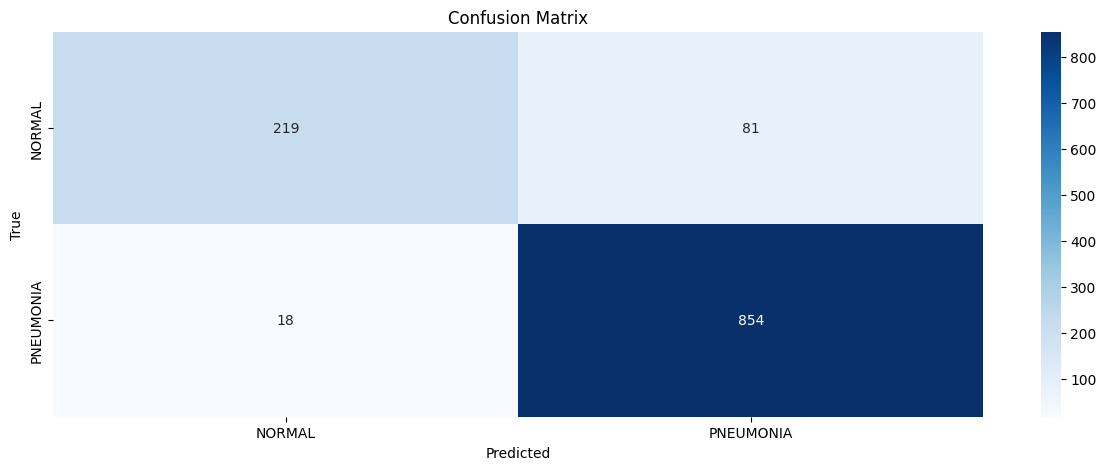

Recall black_pixel :  0.8678804855275444
Recall ratio :  0.8919076655052265


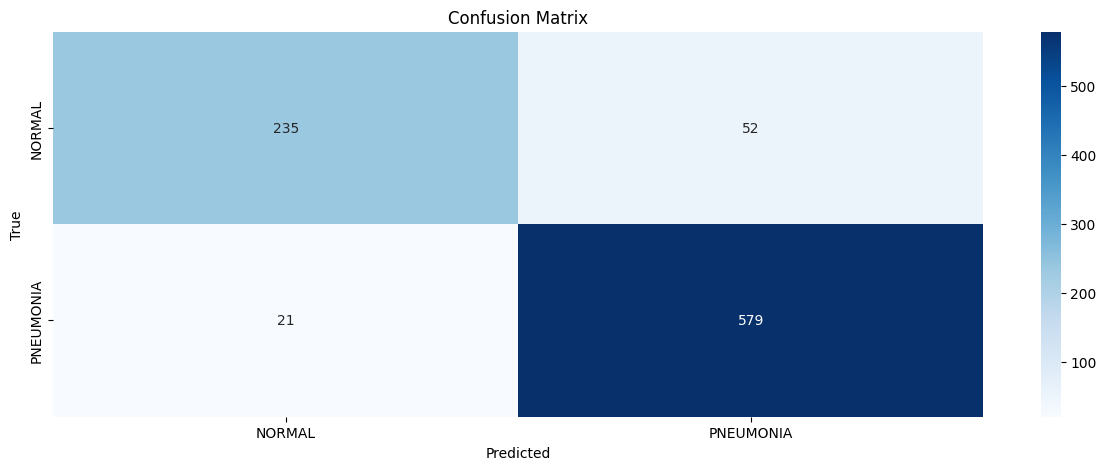

Recall ratio_black_pixel :  0.8852654301247203


{'all': 0.9155290102389079,
 'black_pixel': 0.8789308176100629,
 'ratio': 0.9177001127395716,
 'ratio_black_pixel': 0.8862275449101796}

In [25]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=5)
)

fit_and_score_each_dataset(model)

In [ ]:
# model = make_pipeline(
#     FlattenTransformer(),
#     KNeighborsClassifier(n_neighbors=5)
# )
# 
# use_ratio_black_pixel_dataset()
# X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
# model.fit(X_train, y_train)
# print("accuracy : ", model.score(X_test, y_test))